In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import re
import random
import csv

/home/ziyi/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Network Parameters
num_input = 6
timesteps = 80 # timesteps
num_hidden = 100 # hidden layer num of features
num_output= 1

In [3]:
def read_sensor(filename):
    with open(filename, "r") as csvfile:
        reader = csv.reader(csvfile)
        dataset = [row[17:23] for row in reader]
        #data_x
        return np.array(dataset)
    
def read_xml(filename, length):
    f = open(filename)
    cts = f.read()
    f.close()

    p_foot = re.compile(r'<WhichFoot>(.*?)</WhichFoot>')
    all_foot = p_foot.findall(cts)

    p_time = re.compile(r'<Time>(.*?)</Time>')
    all_time = p_time.findall(cts)

    strike_times = []
    #L-1 R-0
    strike_times.append([0.0, 0.5])
    for i in range(len(all_foot)):
        if(all_foot[i]=='L'):
            strike_times.append([float(all_time[i]), 1])
        else:
            strike_times.append([float(all_time[i]), 0])
    strike_times[-1][1] = 0.5
    strike_times.append([length/25.0, 0.5])

    window_y = []
    strike_index=0
    for i in range(length):
        if(i/25.0 >= strike_times[strike_index+1][0]):
            strike_index += 1
        window_y.append([strike_times[strike_index][1]])

    p_info = re.compile(r'<StartTime>(.*?)</StartTime>\n\t<EndTime>(.*?)</EndTime>\n\t<NSteps>(.*?)</NSteps>\n\t<Direction>(.*?)</Direction>')
    all_info = p_info.findall(cts)#start_time, end_time, step_num, direction

    for i in range(len(all_info)):
        if(all_info[i][3][:4]=='Turn'):
#             print(all_info[i])
            start_time = int(float(all_info[i][0])*25)
            end_time = int(float(all_info[i][1])*25)
#             print('start and end time : ', all_info[i][0], all_info[i][1])
            for t in range(start_time-1, end_time):
                window_y[t] = [0.5]

#     print(len(window_y))  
    return window_y

def add_data(path, person, phone_location, assistant):
    data_x = read_sensor('weallwalk/sensor/iPhoneSensors_T'+str(path)+'_ID'+str(person)+'_'+phone_location+'_'+assistant+'.csv')
    data_y = read_xml('weallwalk/xml/T'+str(path)+'_ID'+str(person)+'_'+assistant+'.xml', len(data_x))
    
    split_x, split_x_part = [], []
    split_y, split_y_part = [], []
    for i in range(len(data_y)):
        if(data_y[i][0]!=0.5):
            split_y_part.append(data_y[i])
            split_x_part.append(data_x[i])
        else:
            if(len(split_y_part)>0):
                split_y.append(split_y_part)
                split_x.append(split_x_part)
                split_y_part = []
                split_x_part = []
    
    data_x_seq, data_y_seq = [], []
    for i in range(len(split_x)):
        data_x_part, data_y_part = [], []
        for j in range(len(split_x[i])-timesteps):
            x = split_x[i][j:j+timesteps]
            y = split_y[i][j+timesteps]
            data_x_part.append(x)
            data_y_part.append(y)
        if(len(data_x_part)>0):
            data_x_seq.append(data_x_part)
            data_y_seq.append(data_y_part)
    
    return data_x_seq, data_y_seq

In [4]:
data_x_seq, data_y_seq = add_data(1, 1, '1L', 'GD')
print(len(data_y_seq))
print([len(i) for i in data_y_seq])
print(sum([len(i) for i in data_y_seq]))
# print(data_y_seq)

4
[71, 134, 927, 73]
1205


In [5]:
step_data_list = []
for i in range(1,6):
    step_data_list.append([i, 1, '1L', 'WC'])
    step_data_list.append([i, 1, '2R', 'WC'])
    step_data_list.append([i, 2, '1L', 'WC'])
    step_data_list.append([i, 2, '2R', 'WC'])
    
    step_data_list.append([i, 3, '1L', 'WC'])
    step_data_list.append([i, 3, '2R', 'WC'])
    step_data_list.append([i, 5, '1L', 'WC'])
    step_data_list.append([i, 5, '2R', 'WC'])
    step_data_list.append([i, 6, '1L', 'WC'])
#     step_data_list.append([i, 6, '2R', 'WC'])
#     step_data_list.append([i, 7, '1L', 'WC'])
#     step_data_list.append([i, 7, '2R', 'WC'])
#     step_data_list.append([i, 8, '1L', 'WC'])
#     step_data_list.append([i, 8, '2R', 'WC'])   

step_data_list.append([7, 9, '1L', 'WC'])
step_data_list.append([8, 9, '1L', 'WC'])
step_data_list.append([9, 10, '1L', 'WC'])
step_data_list.append([10, 10, '1L', 'WC'])                          

# step_data_list.append([7, 9, '2R', 'WC'])
# step_data_list.append([8, 9, '2R', 'WC'])
# step_data_list.append([9, 10, '2R', 'WC'])
# step_data_list.append([10, 10, '2R', 'WC'])
    
print(step_data_list)

[[1, 1, '1L', 'WC'], [1, 1, '2R', 'WC'], [1, 2, '1L', 'WC'], [1, 2, '2R', 'WC'], [1, 3, '1L', 'WC'], [1, 3, '2R', 'WC'], [1, 5, '1L', 'WC'], [1, 5, '2R', 'WC'], [1, 6, '1L', 'WC'], [2, 1, '1L', 'WC'], [2, 1, '2R', 'WC'], [2, 2, '1L', 'WC'], [2, 2, '2R', 'WC'], [2, 3, '1L', 'WC'], [2, 3, '2R', 'WC'], [2, 5, '1L', 'WC'], [2, 5, '2R', 'WC'], [2, 6, '1L', 'WC'], [3, 1, '1L', 'WC'], [3, 1, '2R', 'WC'], [3, 2, '1L', 'WC'], [3, 2, '2R', 'WC'], [3, 3, '1L', 'WC'], [3, 3, '2R', 'WC'], [3, 5, '1L', 'WC'], [3, 5, '2R', 'WC'], [3, 6, '1L', 'WC'], [4, 1, '1L', 'WC'], [4, 1, '2R', 'WC'], [4, 2, '1L', 'WC'], [4, 2, '2R', 'WC'], [4, 3, '1L', 'WC'], [4, 3, '2R', 'WC'], [4, 5, '1L', 'WC'], [4, 5, '2R', 'WC'], [4, 6, '1L', 'WC'], [5, 1, '1L', 'WC'], [5, 1, '2R', 'WC'], [5, 2, '1L', 'WC'], [5, 2, '2R', 'WC'], [5, 3, '1L', 'WC'], [5, 3, '2R', 'WC'], [5, 5, '1L', 'WC'], [5, 5, '2R', 'WC'], [5, 6, '1L', 'WC'], [7, 9, '1L', 'WC'], [8, 9, '1L', 'WC'], [9, 10, '1L', 'WC'], [10, 10, '1L', 'WC']]


In [6]:
data_x, data_y = [], []
for i in step_data_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    for dx in data_x_segement:
        data_x.extend(dx)
    for dy in data_y_segement:
        data_y.extend(dy)
    
print(len(data_x))
print(len(data_y))

150860
150860


In [7]:
order = list(range(0,len(data_x),1))
random.shuffle(order)

train_x = [data_x[i] for i in order]
train_y = [data_y[i] for i in order]

print(len(train_x))

150860


In [64]:
# step_test_list = []
# for i in range(6,7):
#     step_test_list.append([i, 1, '1L', 'WC'])
#     step_test_list.append([i, 1, '2R', 'WC'])
#     step_test_list.append([i, 2, '1L', 'WC'])
#     step_test_list.append([i, 2, '2R', 'WC'])
    
#     step_test_list.append([i, 3, '1L', 'WC'])
#     step_test_list.append([i, 3, '2R', 'WC'])
#     step_test_list.append([i, 5, '1L', 'WC'])
#     step_test_list.append([i, 5, '2R', 'WC'])
#     step_test_list.append([i, 6, '1L', 'WC'])
    
# for i in range(1,7):
# #     step_test_list.append([i, 6, '2R', 'WC'])
#     step_test_list.append([i, 7, '1L', 'WC'])
#     step_test_list.append([i, 7, '2R', 'WC'])
#     step_test_list.append([i, 8, '1L', 'WC'])
#     step_test_list.append([i, 8, '2R', 'WC'])      
    
# step_test_list.append([7, 9, '2R', 'WC'])
# step_test_list.append([8, 9, '2R', 'WC'])
# step_test_list.append([9, 10, '2R', 'WC'])
# step_test_list.append([10, 10, '2R', 'WC'])    
      
# print(step_test_list)
step_test_list = []

# step_test_list.append([7, 9, '2R', 'WC'])
# step_test_list.append([8, 9, '2R', 'WC'])
# step_test_list.append([9, 10, '2R', 'WC'])
# step_test_list.append([10, 10, '2R', 'WC'])    

for i in range(1,7):
#     step_test_list.append([i, 6, '2R', 'WC'])
    step_test_list.append([i, 7, '1L', 'WC'])
    step_test_list.append([i, 7, '2R', 'WC'])
    step_test_list.append([i, 8, '1L', 'WC'])
    step_test_list.append([i, 8, '2R', 'WC'])     

for i in range(6,7):
    step_test_list.append([i, 1, '1L', 'WC'])
    step_test_list.append([i, 1, '2R', 'WC'])
    step_test_list.append([i, 2, '1L', 'WC'])
    step_test_list.append([i, 2, '2R', 'WC'])
    
    step_test_list.append([i, 3, '1L', 'WC'])
    step_test_list.append([i, 3, '2R', 'WC'])
    step_test_list.append([i, 5, '1L', 'WC'])
    step_test_list.append([i, 5, '2R', 'WC'])
    step_test_list.append([i, 6, '1L', 'WC']) 
      
print(step_test_list)

[[1, 7, '1L', 'WC'], [1, 7, '2R', 'WC'], [1, 8, '1L', 'WC'], [1, 8, '2R', 'WC'], [2, 7, '1L', 'WC'], [2, 7, '2R', 'WC'], [2, 8, '1L', 'WC'], [2, 8, '2R', 'WC'], [3, 7, '1L', 'WC'], [3, 7, '2R', 'WC'], [3, 8, '1L', 'WC'], [3, 8, '2R', 'WC'], [4, 7, '1L', 'WC'], [4, 7, '2R', 'WC'], [4, 8, '1L', 'WC'], [4, 8, '2R', 'WC'], [5, 7, '1L', 'WC'], [5, 7, '2R', 'WC'], [5, 8, '1L', 'WC'], [5, 8, '2R', 'WC'], [6, 7, '1L', 'WC'], [6, 7, '2R', 'WC'], [6, 8, '1L', 'WC'], [6, 8, '2R', 'WC'], [6, 1, '1L', 'WC'], [6, 1, '2R', 'WC'], [6, 2, '1L', 'WC'], [6, 2, '2R', 'WC'], [6, 3, '1L', 'WC'], [6, 3, '2R', 'WC'], [6, 5, '1L', 'WC'], [6, 5, '2R', 'WC'], [6, 6, '1L', 'WC']]


In [65]:
test_x, test_y=[], []
for i in step_test_list:
    data_x_segement, data_y_segement = add_data(i[0], i[1], i[2], i[3])
    test_x.extend(data_x_segement)
    test_y.extend(data_y_segement)
#     test_x.append(data_x_segement)
#     test_y.append(data_y_segement)
    
print(len(test_x))
print(len(test_y))

print([len(i) for i in test_y])

148
148
[90, 246, 988, 110, 90, 246, 988, 110, 83, 219, 910, 63, 83, 219, 910, 63, 131, 1403, 178, 35, 131, 1403, 178, 35, 70, 1340, 130, 46, 70, 1340, 130, 46, 1329, 363, 1329, 363, 1707, 344, 1707, 344, 310, 1198, 156, 1119, 96, 827, 107, 843, 310, 1198, 156, 1119, 96, 827, 107, 843, 381, 1617, 270, 1236, 350, 889, 129, 832, 381, 1617, 270, 1236, 350, 889, 129, 832, 30, 523, 807, 337, 459, 344, 1377, 30, 523, 807, 337, 459, 344, 1377, 111, 362, 811, 294, 492, 322, 1632, 111, 362, 811, 294, 492, 322, 1632, 744, 1306, 22, 744, 1306, 22, 17, 798, 1375, 17, 798, 1375, 19, 879, 1625, 24, 19, 879, 1625, 24, 29, 992, 1480, 54, 29, 992, 1480, 54, 51, 677, 1254, 4, 51, 677, 1254, 4, 13, 731, 1422, 16, 13, 731, 1422, 16, 41, 695, 1302, 20]


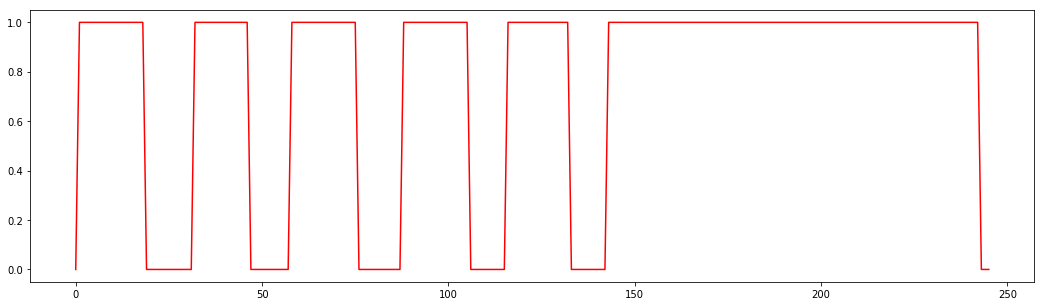

In [66]:
plt.figure(figsize=(18, 5))
plt.plot([i[0] for i in test_y[1]], 'r')
plt.show()

In [67]:
NUM_LAYERS=3

def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, state_is_tuple=True)
    return lstm_cell
#     lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)#, forget_bias=1.0)
#     cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=0.5)
#     return cell

graph = tf.Graph()
with graph.as_default(), tf.device('/gpu:0'):
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    
    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([num_hidden, num_output]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([num_output]))
    }
    
    def RNN(x, weights, biases):
        x = tf.unstack(x, timesteps, 1)
        
        cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])
        outputs, state = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
        outputs = tf.transpose(outputs, [1,0,2])

        return tf.matmul(outputs[-1], weights['out']) + biases['out']
    

    logits = RNN(X, weights, biases)
    mean_train = tf.reduce_mean(X)
    loss = tf.reduce_mean(tf.squared_difference(logits, Y))
    #loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    
    saver = tf.train.Saver()

In [68]:
batch_size = 256
batch_start = 0;
train_length = len(train_x)
print(train_length)

train_x_extend = [i for i in train_x]
train_y_extend = [i for i in train_y]

print(len(train_x_extend))

150860
150860


In [69]:
if(len(train_x_extend)==len(train_x)):
    train_x_extend.extend(train_x[0:batch_size])
    train_y_extend.extend(train_y[0:batch_size])
print(len(train_x_extend))

151116


In [70]:
def cal_accuarcy(y, _y):
    count = 0
    for i in range(0, len(y)):
        if(y[i][0] == round(_y[i][0])):
            count += 1;
    return count*1.0/len(y)
#     print("train accuarcy : ", count/len(y))

In [79]:
training_steps = 4001

config = tf.ConfigProto(allow_soft_placement=True)
# config.gpu_options.allocator_type = 'BFC'
# config.gpu_options.per_process_gpu_memory_fraction = 0.40
with tf.Session(graph=graph, config=config) as session:
    saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
#     saver.restore(session, "lstm_check/my-model-gpu-error-metric-dropout2.ckpt-6000")
#     tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(training_steps):      
        feed_dict = {X: train_x[batch_start:batch_start+batch_size], Y: train_y[batch_start:batch_start+batch_size]}
        _, l, predictions, m = session.run([optimizer, loss, logits, mean_train], feed_dict = feed_dict)
        if (step % 200 == 0):
            train_accuarcy = cal_accuarcy(train_y[batch_start:batch_start+batch_size], predictions)
            print('Loss at step %d: %f, train accuarcy : %f' % (step, l, train_accuarcy))
            #train accuarcy
        if (step % 1000 == 0):
            saver.save(session, 'lstm_check/my-model-gpu-error-metric-nodropout3-wc.ckpt', global_step=step+2000)
        batch_start += batch_size
        if(batch_start>=train_length):
            batch_start -=train_length
#     train_loss, train_logits = session.run([loss,logits], feed_dict={X: train_x, Y: train_y})
#     test_loss, test_logits = session.run([loss,logits], feed_dict={X: test_x, Y: test_y})
    test_loss, test_logits = [], []
    for i in range(len(test_x)):
#         saver.restore(session, tf.train.latest_checkpoint('lstm_check'))
        test_loss_part, test_logits_part = session.run([loss,logits], feed_dict={X: test_x[i], Y: test_y[i]})
        test_loss.append(test_loss_part)
        test_logits.append(test_logits_part)

INFO:tensorflow:Restoring parameters from lstm_check/my-model-gpu-error-metric-nodropout3-wc.ckpt-2000
Initialized
Loss at step 0: 0.072211, train accuarcy : 0.910156
Loss at step 200: 0.066555, train accuarcy : 0.917969
Loss at step 400: 0.074190, train accuarcy : 0.906250
Loss at step 600: 0.058098, train accuarcy : 0.925781
Loss at step 800: 0.062353, train accuarcy : 0.917969
Loss at step 1000: 0.064819, train accuarcy : 0.910156
Loss at step 1200: 0.052417, train accuarcy : 0.917969
Loss at step 1400: 0.061646, train accuarcy : 0.906250
Loss at step 1600: 0.061984, train accuarcy : 0.914062
Loss at step 1800: 0.066481, train accuarcy : 0.914062
Loss at step 2000: 0.077251, train accuarcy : 0.894531
Loss at step 2200: 0.048151, train accuarcy : 0.937500
Loss at step 2400: 0.071444, train accuarcy : 0.882812
Loss at step 2600: 0.047106, train accuarcy : 0.925781
Loss at step 2800: 0.038683, train accuarcy : 0.941406
Loss at step 3000: 0.068424, train accuarcy : 0.906250
Loss at step

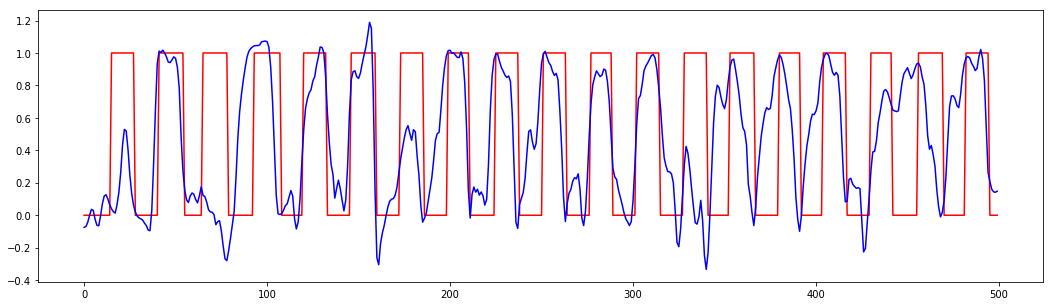

In [80]:
plt.figure(figsize=(18, 5))
start=0
end=500
plt.plot([i[0] for i in test_y[100][start:end]], 'r')
plt.plot([i[0] for i in test_logits[100][start:end]], 'b')
plt.show()

In [81]:
print("test loss : ", test_loss)
print(len(test_loss))

test loss :  [0.18111616, 0.38219312, 0.28236181, 0.38022473, 0.81369126, 0.64656943, 0.63532722, 0.68954772, 0.42191783, 0.43706203, 0.3698155, 0.50562686, 0.70132804, 0.77337193, 0.69711304, 0.80692494, 0.21217798, 0.27447724, 0.25683019, 0.14619815, 0.7457571, 0.62111539, 0.78533918, 0.78315747, 0.49732605, 0.42839834, 0.51842386, 0.59107625, 0.71192634, 0.70082188, 0.71854222, 0.74155313, 0.34106216, 0.24629046, 0.61768377, 0.55945432, 0.47584847, 0.51958925, 0.68525058, 0.69476408, 0.32402918, 0.36486229, 0.40195784, 0.352992, 0.29122263, 0.41311896, 0.4825525, 0.47822094, 0.7554217, 0.58207631, 0.58814305, 0.47546655, 0.61464286, 0.4461385, 0.74772382, 0.56920505, 0.53840679, 0.44608381, 0.41351926, 0.43438464, 0.63370097, 0.46969071, 0.53005826, 0.50390768, 0.73429674, 0.72728944, 0.73792428, 0.77943206, 0.57130915, 0.75544226, 0.81709927, 0.76448947, 0.43476614, 0.24043989, 0.20393282, 0.194006, 0.30009106, 0.32930139, 0.40428424, 0.76630992, 0.66222239, 0.64212859, 0.55774933,

In [82]:
test_logits_bin = []
for t in test_logits:
    test_logits_part = [[round(i[0])] for i in t]
    for i in range(1, len(test_logits_part)-1):
        if(test_logits_part[i-1][0]!=test_logits_part[i][0] and test_logits_part[i-1][0]==test_logits_part[i+1][0]):
            test_logits_part[i][0]=test_logits_part[i-1][0]    
    test_logits_bin.append(test_logits_part)

count = 0
total = 0
for i in range(0, len(test_x)):
    total += len(test_y[i])
    for j in range(0, len(test_y[i])):
        if(test_y[i][j][0] == test_logits_bin[i][j][0]):
            count += 1

print(count)
print(total)
print("test accuarcy : ", count*1.0/total)

41461
85214
test accuarcy :  0.4865515056211421


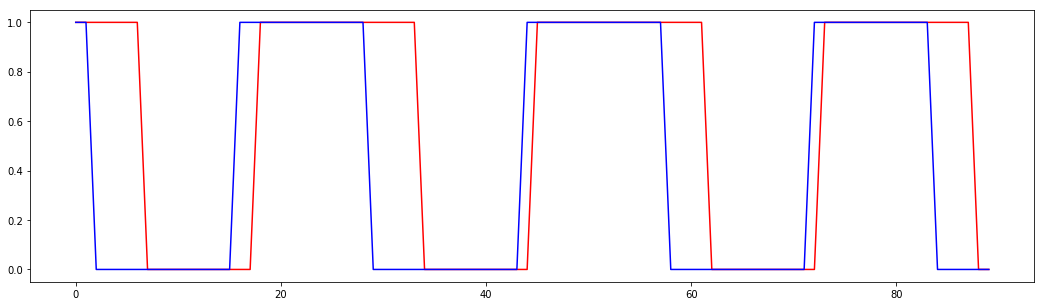

In [83]:
plt.figure(figsize=(18, 5))
start=0
end=500
plt.plot([i[0] for i in test_y[0][start:end]], 'r')
plt.plot([i[0] for i in test_logits_bin[0][start:end]], 'b')
plt.show()

In [84]:
#test_y      [[0], [0], [1]]
#test_logits 

step_time_actual, step_time_predict= [], []

for i in range(0, len(test_x)):
    step_time_actual_part, step_time_predict_part= [], []
    for j in range(0, len(test_y[i])-1):
        if(abs(test_y[i][j][0]-test_y[i][j-1][0])>0.5):
            step_time_actual_part.append(j)
    #     if(abs(test_logits[i][0]-test_logits[i-1][0])>0.5):
        if(abs(test_logits_bin[i][j][0]-test_logits_bin[i][j-1][0])>0.5):
            step_time_predict_part.append(j)
    step_time_actual.append(step_time_actual_part)
    step_time_predict.append(step_time_predict_part)

print([len(i) for i in step_time_actual])   
print([len(i) for i in step_time_predict])

[8, 12, 76, 8, 8, 12, 76, 8, 6, 16, 66, 4, 6, 16, 66, 4, 10, 108, 14, 2, 10, 108, 14, 2, 6, 90, 10, 4, 6, 90, 10, 4, 104, 28, 104, 28, 108, 24, 108, 24, 24, 98, 10, 92, 7, 67, 8, 68, 24, 98, 10, 92, 7, 67, 8, 68, 26, 100, 14, 88, 16, 64, 10, 58, 26, 100, 14, 88, 16, 64, 10, 58, 2, 38, 62, 26, 36, 26, 104, 2, 38, 62, 26, 36, 26, 104, 8, 28, 50, 22, 34, 22, 98, 8, 28, 50, 22, 34, 22, 98, 58, 104, 2, 58, 104, 2, 2, 52, 92, 2, 52, 92, 2, 58, 114, 2, 2, 58, 114, 2, 2, 52, 92, 4, 2, 52, 92, 4, 2, 50, 94, 0, 2, 50, 94, 0, 2, 48, 92, 0, 2, 48, 92, 0, 4, 52, 99, 2]
[8, 16, 76, 6, 7, 20, 90, 8, 4, 16, 56, 4, 6, 18, 66, 4, 10, 114, 14, 2, 9, 120, 13, 2, 6, 86, 6, 4, 6, 96, 10, 4, 112, 32, 116, 34, 96, 24, 110, 24, 24, 102, 10, 110, 6, 76, 8, 70, 26, 109, 14, 68, 8, 60, 8, 80, 30, 92, 16, 68, 20, 46, 10, 40, 28, 101, 20, 88, 26, 66, 10, 56, 2, 42, 64, 24, 38, 26, 116, 2, 38, 62, 20, 39, 26, 106, 6, 24, 54, 20, 32, 22, 102, 10, 27, 60, 22, 36, 22, 106, 56, 110, 0, 62, 102, 2, 2, 50, 76, 2, 58, 95, 

In [85]:
print(step_time_actual[0])
print(step_time_predict[0])

[0, 7, 18, 34, 45, 62, 73, 88]
[0, 2, 16, 29, 44, 58, 72, 84]


In [86]:
total_step_count = sum([len(i) for i in step_time_actual])
metric1_undercount = 0
metric2_undercount = 0
metric1_overcount = 0
metric2_overcount = 0

for i in range(len(test_x)):
    step_count = len(step_time_actual[i])
    undercount = 0
    overcount = 0

    for j in range(1, step_count):
        gap_count = [t for t in step_time_predict[i] if t>=step_time_actual[i][j-1] and t<step_time_actual[i][j]]
    #     print(gap_count)
        if(len(gap_count)>1):
            overcount += len(gap_count)-1
        if(len(gap_count)<1):
            undercount += 1
    
    metric1_undercount += undercount
    metric1_overcount += overcount
#     print(undercount, overcount)
#     print('undercount : ', undercount*1.0/step_count)
#     print('overcount : ', overcount*1.0/step_count)
    diff = len(step_time_predict[i])-len(step_time_actual[i])
#     if(diff==0):
#         print("segement correct!")

    if(diff<0):
#         print('segement undercount : ', 1-len(step_time_predict[i])*1.0/len(step_time_actual[i]))
        metric2_undercount -= diff
    if(diff>0):
#         print('segement overcount : ', 1-len(step_time_actual[i])*1.0/len(step_time_predict[i]))
        metric2_overcount += diff

print('------------------')
print("total undercount metric 1 : ", metric1_undercount*1.0/total_step_count)
print("total overcount metric 1 : ", metric1_overcount*1.0/total_step_count)
print("total undercount metric 2 : ", metric2_undercount*1.0/total_step_count)
print("total overcount metric 2 : ", metric2_overcount*1.0/total_step_count)

------------------
total undercount metric 1 :  0.14240663900414938
total overcount metric 1 :  0.16033195020746888
total undercount metric 2 :  0.030705394190871368
total overcount metric 2 :  0.048132780082987554
